<a href="https://colab.research.google.com/github/MevrouwHelderder/Assignments/blob/main/Assignment_Shark_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment: 
Take [this dataset](https://www.kaggle.com/felipeesc/shark-attack-dataset). Use all the skills you've learned up until now to answer the following questions as well as possible. 

* What are the most dangerous types of sharks to humans? 
* Are children more likely to be attacked by sharks? 
* Are shark attacks where sharks were provoked more or less dangerous? 
* Are certain activities more likely to result in a shark attack? 

If you feel you can't answer a question based on the dataset alone, feel free to find other datasets and use them in answering the questions.

For each answer you give not only answer the question but also write about the assumptions you made in answering the question. If an assumption or decision possibly created a bias please write about this as well.

# The essentials

In [2]:
# Importing the essentials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

%load_ext google.colab.data_table

In [3]:
# importing the dataframe
path = "/content/drive/MyDrive/attacks.csv"
df = pd.read_csv(path, encoding="ISO-8859-1")

In [4]:
# Making a copy so to not change the original dataset while modifying the shape
attacks_shape = df.copy(deep=True)

# Preparing the basics of the dataframe

In [5]:
# Dropping columns.
attacks_shape = attacks_shape.drop(
    columns=[
        "Date",
        "Time",
        "Case Number",
        "Location",
        "Name",
        "Investigator or Source",
        "pdf",
        "href formula",
        "Area",
        "href",
        "Case Number.1",
        "Case Number.2",
        "original order",
        "Unnamed: 22",
        "Unnamed: 23",
    ]
)

In [6]:
#Checking on the names of the column
list(attacks_shape)

# Renaming columns.
attacks_shape = attacks_shape.rename(
    columns={"Case Number": "Case", "Sex ": "Sex", "Fatal (Y/N)": "Outcome", "Species ": "Species"})

In [7]:
# Dropping rows that have a null value on all columns except for the column "Case".
# Having only a casenumber made them useless by default.
#
# Making a copy to prevent view vs copy issues later on 


relevant_columns = list(attacks_shape.columns[1:])
attacks_shape = attacks_shape.dropna(subset=relevant_columns, how="all").copy(deep=True)


# Helpers
Below are functions that help during one or more parts of the process.
I realise that the functions that handle the non-default missing values
are not my own: we used them in an earlier exercise.

However, they are useful and it would be dumb to pretend they are my own by changing a tiny bit.

So credit where credit is due, thanks Winc!

In [8]:
# Functions to help finding non-default missing values:

# Preparing the functions for locating and adjusting the missing values.
def print_separator(sep, num, msg):
    print("\n")
    print(sep * num)
    print(f"{msg}")
    print(sep * num)

# TACTIC A: find unique values
def look_at_unique_values(column):
    unique_values_cutoff = 50
    unique_values = column.unique()
    num_unique_values = len(unique_values)
    if num_unique_values == len(column):
        print(f"Each value in the column is unique (total: {num_unique_values})")
    elif num_unique_values < unique_values_cutoff:
        print(f"Less than {unique_values_cutoff} unique values:")
        try:
            sorted = np.sort(unique_values)
            print("Values are sorted")
            display(list(sorted))
        except:
            print("Could not sort values")
            display(list(unique_values))
    else:
        print(
            f"More than {unique_values_cutoff} unique values (total: {num_unique_values})"
        )

# TACTIC B: look at the edges
def look_at_edges(df, column_name):
    # inner function
    def show_head_and_tail(values):
        num_items_to_slice = 10
        display(list(values)[:num_items_to_slice])
        display(list(values)[-num_items_to_slice:])

    column = df[column_name]
    unique_values = column.unique()
    try:
        sorted = np.sort(unique_values)
        print("Unique values sorted, head and tail:")
        show_head_and_tail(sorted)
    except TypeError as error:
        print(f"Could not sort values: {error}")
        print("..so let's try filtering NULL values and then sorting")
        print("..there could be a black sheep in the null values")
        non_null_uniques = df.loc[~df[column_name].isnull(), column_name].unique()
        sorted = np.sort(non_null_uniques)
        show_head_and_tail(sorted)

# TACTIC C: casting to a type to see if all the values match the needed type
def cast_to_type(column, maybe_type):
    try:
        column.astype(maybe_type)
        print(f"Casting to {maybe_type} was successful")
    except ValueError as error:
        print(f"Could not cast to {maybe_type}: {error}")

# TACTIC D: display the value count of the column
def value_count(column):
    display(column.value_counts(dropna=False))

# FUNCTION TO CHECK THE DATAFRAME FOR ALL FOUR TACTICS
def find_non_default_missing_values(df, column_name, maybe_type):
    long_separator_amount = 80
    short_separator_amount = 40
    # Print the header
    print_separator(
        "*",
        long_separator_amount,
        f'Finding non default missing values for column "{column_name}"',
    )
    print(f'Column "{column_name}" has datatype: {df.dtypes[column_name]}')
    column = df[column_name]
    # A
    print_separator("-", short_separator_amount, "A: Looking at unique values")
    look_at_unique_values(column)
    # B
    print_separator("-", short_separator_amount, "B: Sorting and looking at the edges")
    look_at_edges(df, column_name)
    # C
    print_separator("-", short_separator_amount, f"C: Casting to type: {maybe_type}")
    cast_to_type(column, maybe_type)
    # D
    print_separator(
        "-",
        short_separator_amount,
        "D: Looking at frequency\nAll default-NULL values will be bunched together as NaN",
    )
    value_count(column)
    print("\n")

# Function to display the default NULL values in the column.
def display_default_null_values(df, column_name):
    nulls = df.loc[df[column_name].isnull()]
    print(f'Number of default null values in "{column_name}": {len(nulls)}')

# Easier to type
nat = np.datetime64("nat")


  

In [9]:
# Function to change values based on a non-nested dictionary
# ⚠️ Mutates df
def replace_multi(df, col, dict):
    df[col] = df[col].replace(dict)
    
# Function to replace a single values with another single value.
# ⚠️ Mutates df
def replace_one(df, col, old_value, new_value):
  df[col] = df[col].replace({old_value : new_value})

# Function to replace multiple values with one value
# ⚠️ Mutates df
def replace_multi_to_one(df, col, old_list, new_value):
  df[col] = df[col].replace(dict.fromkeys(old_list, new_value))

# Function to replace using regular expressions
# ⚠️ Mutates df
def replace_regex(df, col, old_value, new_value):
  df[col] = df[col].str.replace(old_value, new_value, regex=True)


# Cleaning up the columns
Goal: keep only the data needed.

I do apologise beforehand. I suspect on some columns I did more than needed for this assignment. 

Especially when cleaning up/sorting out the last crumbs. 

I realise they probably have no significant influance and that when time and or money are an issue they probably should have been left as the were or even thrown out, depending on the goal.
But I simply had a blast and it tought me so many new skills that I took the opportunity to learn by doing.

I might also have used one tactic on a column but another on a different column. In between working on the different columns I learned a lot and I also experimented to see what worked better.

And lastly: I realise I have written some functions that could perhaps be combined. However, for now I prefer to leave them since they show the steps I took while cleaning up.

In [10]:
# Making a copy to work on, to keep track of the changes
attacks_clean = attacks_shape.copy(deep=True)

In [11]:
# Lowercase all strings and strip whitespace and/or quotationmarks around strings
attacks_clean = attacks_clean.applymap(lambda x: x.lower() if isinstance(x, str) else x)
attacks_clean = attacks_clean.applymap(lambda x: x.strip('" ') if isinstance(x, str) else x)

# Column: Species

In [12]:
# Checking how everthing looks and what stands out: 
# find_non_default_missing_values(attacks_clean, 'Species', 'string')

In [13]:
# Extract the species from the string where possible

# if any for of null: change to None
# if empty after stripping whitespace: change to None
# if the word shark is there: return that plus the word before "shark"
# else: return the original plus "check: "

def tidy(x):                                
    if pd.isna(x):                                    
        return None
    elif len(x.strip()) == 0:                         
        return None
    elif "shark" in x:                                
        return re.search(r"(\S+\s*)?shark", x).group()
    else:
        return f"check: {x}"                          


attacks_clean["Species"] = attacks_clean["Species"].apply(tidy)

In [14]:
# Things we can now safely change to "unconfirmed"
# Values that mention certain words.
# Values that mention no species but mention measurements like 20"] 

no_species = [
    "invalid",
    "unidentified",
    "questionable",
    "possibly",
    "not confirmed",
    "unconfirmed",
    "doubtful",
    "captive",
    "unknown",
    "several",
    "colored",
    "large shark",
    "female shark",
    "grey shark",
    "two shark",
    "the shark",
    "from shark",
    "little shark",
    "larger shark",
    "red shark",
    "young shark",
    "for shark",
    "metre shark",
    "juvenile shark",
    "gray shark",
    "finned shark",
    "small shark"
]

# one or more digits followed by ' or " followed by
# zero or more ] followed by shark, whitespaces optional
inches = r'\d+\s*(["\']{1,})\s*\]*\s*shark'

# string containing two or less letters or digits or -
# followed by shark, whitespaces optional
small_string = r"^[a-z0-9-]{0,2}\s*shark$"

# lb or kg or foot followed by zero or more ] followed by shark, whitespaces optional
measurements = r"(kg|lb|foot)\s*\]*\s*shark"


def tidy_more(x):
    if x is not None and (
        any(word in x for word in no_species)
        or re.search(inches, x)
        or re.search(small_string, x)
        or re.search(measurements, x)
    ):
        return "unconfirmed"
    else:
        return x


attacks_clean["Species"] = attacks_clean["Species"].apply(tidy_more)

In [15]:
# removing quotation marks and this weird little fellas that look the same but are different:  
def remove_weirdos(x):
    if x is None:
        return None
    else:
        return re.sub(r'["]+', "", x)

attacks_clean["Species"] = attacks_clean["Species"].apply(remove_weirdos)

In [16]:
# Checking all values that I previously marked as 'check'
mask_species = attacks_clean["Species"].str.contains("check", na=False)
attacks_clean[mask_species]

# Changing to the right species where possible
correct_species = [
    "blue pointer",
    "wobbegong",
    "whaler",
    "hammerhead",
    "porbeagle",
    "whitetip",
    "horn",
]

def correct_checks(x):
    if x is not None and ("check" in x):
        for word in correct_species:
            if word in x:
                return f"{word} shark"
        else:
            return "unconfirmed"
    else:
        return x

attacks_clean["Species"] = attacks_clean["Species"].apply(lambda x: correct_checks(x))


In [17]:
# Checking last crumbs to clean up:
# Replace a few different writings of the same species

replacing = {"seven-gill shark": "sevengill shark",
        "7-gill shark": "sevengill shark",
        "sevengill  shark": "sevengill shark",
        "black-tipped shark": "blacktip shark",
        "blacktip  shark": "blacktip shark",
        "sand shark": "sandshark",
        "zambesi shark": "zambezi shark"}

replace_multi(attacks_clean, "Species", replacing)

In [18]:
# attacks_clean['Species'].value_counts().head(50)
# attacks_clean['Species'].value_counts().tail(50)

# Column: Case

In [19]:
# Checking how everything looks and what stands out: 
# find_non_default_missing_values(attacks_clean, "Case", "string")

# There are some duplicate values. 
# Checking what they mean: 

# attacks_clean[attacks_clean.duplicated('Case', keep=False)]

# They might indicatie cases where more then one person was attacked. 
# The columns regarding location and time might help here if needed but since 
# there are few and they seem irrelevant to our questions I will leave them for now

# Column: Type

In [20]:
# Checking how everything looks and what stands out: 
# find_non_default_missing_values(attacks_clean, "Type", "string")

In [21]:
# Replace a few different values that all mean the same plus replace np.nan.
replace_type = {"boating" : "boat", "boatomg" : "boat", np.nan: None}

replace_multi(attacks_clean, "Type", replace_type)

In [22]:
# attacks_clean["Type"].value_counts().head(50)
# attacks_clean["Type"].value_counts().tail(50)

# Column: Activity

In [23]:
# Checking how everything looks and what stands out: 
# find_non_default_missing_values(attacks_clean, "Activity", "string")

In [24]:
# Replacing the null values
replace_activity = {".": None, np.nan: None}
replace_multi(attacks_clean, "Activity", replace_activity)

# Boarding seems to be a substantial part. Combining different spellings of the same value
boarding = ["boogie boarding", "paddle boarding", "body-boarding", "body boarding", "paddle-boarding"]
replace_multi_to_one(attacks_clean, "Activity", boarding, "bodyboarding")

In [25]:
# Taking the top 60 values as categories and dividing the other values, where possible,
# into those categories.

top_activities = list(attacks_clean["Activity"].value_counts().head(60).index)

def activities_checks(x):
    if x is not None:
      for word in top_activities:
          if word in x:
              return word
      else:
          return x

attacks_clean["Activity"] = attacks_clean["Activity"].apply(lambda x: activities_checks(x))

In [26]:
# attacks_clean["Activity"].value_counts().head(50)
# attacks_clean["Activity"].value_counts().tail(50)

# Column: Outcome

In [27]:
# Checking how everything looks and what stands out: 
# find_non_default_missing_values(attacks_clean, "Outcome", "string")

In [28]:
# Changing values to corresponding categories
replace_outcome = {"n" : "nonfatal", "y" : "fatal", "m" : "unconfirmed", "2017": "unconfirmed", "unknown": "unconfirmed", np.nan : None}
replace_multi(attacks_clean, "Outcome", replace_outcome)

In [29]:
attacks_clean["Outcome"].value_counts().head(50)
# attacks_clean["Outcome"].value_counts().tail(50)

nonfatal       4301
fatal          1389
unconfirmed      73
Name: Outcome, dtype: int64

# Column: Age

In [30]:
# Checking how everything looks and what stands out: 
# find_non_default_missing_values(attacks_clean, "Age", "string")

In [31]:
# change NaN to None
replace_age= {np.nan : None, "": None}
replace_multi(attacks_clean, "Age", replace_age)

In [32]:
# convert non-null values to string
non_null = attacks_clean["Age"].notnull()
attacks_clean.loc[non_null, "Age"] = attacks_clean.loc[non_null, "Age"].astype(str)

In [33]:
# Making a new column that adds age group, based on the age

# Sorting ages by range
child = [str(i) for i in range(0, 13)]
adolescent = [str(i) for i in range(13, 18)]
adult = [str(i) for i in range(18, 130)]

# Sorting all the values that describe the age in words
child_words = ["child", "2 to 3 months", "9 months", "18 months", "2½", "both 11", "6½"]
adolescent_words = ["teen", "teens"]
adult_words = ["adult" , "middle-age", "(adult)", "20s", "30s", "40s", "50s", "elderly", "60's", "60s", "mid-20s", "mid-30s", "ca. 33"]

# Sorting into age groups, also tackling values that mention multiple ages
# by splitting into seperate ages, removing any empty strings 
# and sorting into the right group IF all ages belong to the same group 
def age_groups(age):
    if age is None:
        return age
    else:
        age_list = re.split(r'[,&\s?]|(?:\s*(?:to|or)\s*)', age) 
        age_list = list(filter(None, age_list))  
        if all(word in child for word in age_list) or age in child_words:
            return "child"
        elif all(word in adolescent for word in age_list) or age in adolescent_words:
            return "adolescent"
        elif all(word in adult for word in age_list) or age in adult_words:
            return "adult"
        else:
            return None

attacks_clean.insert(4, "Age_group", attacks_clean["Age"].apply(age_groups))

# Column: Injury

I noticed a lot of injuries were the same but with different spellings.
I sorted them into broader groups.

It could have been sorted even more but I found this to be a good medium.

In [34]:
# Checking how everything looks and what stands out: 
# find_non_default_missing_values(attacks_clean, "Injury", "string")

In [35]:
# change NaN to None
replace_injury= {np.nan : None, "": None}
replace_multi(attacks_clean, "Injury", replace_injury)

In [36]:
# Removing some words for better sorting, stripping whitespace
removable = r"\bleft\b|\bright\b|\bminor\b|\bsevere\b|\blower\b|\bto dorsum of\b|\bsmall\b"
replace_regex(attacks_clean, "Injury", removable, "no injury")
# stripping whitespace
attacks_clean["Injury"] = attacks_clean["Injury"].str.strip()

# Correcting some words for better sorting
replace_one(attacks_clean, "Injury", "injury", "injuries")

# Replace values that contain "fatal" with just "fatal"
replace_regex(attacks_clean, "Injury", r".*\bfatal\b.*", "fatal")

# Replace values that contain "no injury" with just "no injury"
replace_regex(attacks_clean, "Injury", r".*\bno injury\b.*", "no injury")

In [37]:
# Combining laceration/lacerated/etc.

# Replace "laceration" with "lacerations"
replace_regex(attacks_clean, "Injury", r"\blaceration\b", "lacerations")
# Replace "lacerated" with "lacerations"
replace_regex(attacks_clean, "Injury", r"\blacerated\b", "lacerations")

# If "lacerations" is present: place it at the front of the string
def move_lacerations_to_front(injury):
    if injury is None:
        return injury
    else: 
      if "lacerations" in injury:
         return "lacerations " + injury.replace("lacerations", "").strip()
      else:
         return injury.strip()

# Apply the function to the "Injury_2" column
attacks_clean["Injury"] = attacks_clean["Injury"].apply(move_lacerations_to_front)

In [38]:
# Combining injured/injury/etc.

# Replace "injuries" with "injury"
replace_regex(attacks_clean, "Injury", r"\binjuries\b", "injury")
# Replace "injured" with "injury to"
replace_regex(attacks_clean, "Injury", r"\binjured\b", "injury to")

# If "injury to" is present: place it at the front of the string
def move_injury_to_front(injury):
    if injury is None:
        return injury
    else: 
      if "injury to" in injury:
         return "injury to " + injury.replace("injury to", "").strip()
      else:
         return injury.strip()

# Apply the function to the "Injury_2" column
attacks_clean["Injury"] = attacks_clean["Injury"].apply(move_injury_to_front)

In [39]:
# Remove double whitespaces
replace_regex(attacks_clean, "Injury", r"\s{2,}", " ")

In [40]:
# Checking how is looks now: 
# attacks_clean["Injury"].value_counts().head(20)
# attacks_clean["Injury"].value_counts().tail(20)

# Column: Sex
probably unnescessary for these questions but I'm curious about the differences

In [41]:
# Checking how everything looks and what stands out: 
# find_non_default_missing_values(attacks_clean, "Sex", "string")

In [42]:
# Changing Nan and the three unspecified ones to None.
replace_sex= [np.nan, "n", "lli", "."]
replace_multi_to_one(attacks_clean, "Sex", replace_sex, None)

# Column: Country

In [43]:
# Checking how everything looks and what stands out: 
# find_non_default_missing_values(attacks_clean, "Country", "string")

In [44]:
# Changing nan to None
replace_one(attacks_clean, "Country", np.nan, None)

# Column: Year

In [45]:
# Checking how everything looks and what stands out: 
# find_non_default_missing_values(attacks_clean, "Year", "int64")

In [46]:
# Change to type string,  stripping the .0 from the right sides
attacks_clean["Year"] = attacks_clean["Year"].astype(str).str.rstrip('.0')

In [47]:
# Changing to None if there is no complete year available

attacks_clean["Year"] = attacks_clean["Year"].apply(lambda x: None if len(str(x)) < 4 else x)

In [48]:
# attacks_clean["Year"].value_counts().head(60)
# attacks_clean["Year"].value_counts().tail(60)

# On to plotting!


In [49]:
# Making a copy to prevent messing up earlier steps: 
shark_attacks = attacks_clean.copy(deep=True)

In [50]:
shark_attacks

,Year,Type,Country,Activity,Age_group,Sex,Age,Injury,Outcome,Species
0,2018,boat,usa,paddling,adult,f,57,no injury,nonfatal,white shark
1,2018,unprovoked,usa,standing,child,f,11,no injury,nonfatal,None
2,2018,invalid,usa,surfing,adult,m,48,no injury,nonfatal,None
3,2018,unprovoked,australia,surfing,None,m,None,no injury,nonfatal,unconfirmed
4,2018,provoked,mexico,diving,None,m,None,lacerations to leg & hand shark provoked incident,nonfatal,tiger shark
...,...,...,...,...,...,...,...,...,...,...
6297,None,unprovoked,australia,diving,None,m,None,fatal,fatal,None
6298,None,unprovoked,australia,diving,None,m,None,fatal,fatal,None
6299,None,unprovoked,usa,swimming,None,m,None,fatal,fatal,None
6300,None,unprovoked,panama,None,None,m,None,fatal,fatal,None


In [52]:
# What are the most dangerous types of sharks to humans?
# what shark caused the most incidents of the top ten


# Are children more likely to be attacked by sharks?
# How many incidents per group
# Is there a difference when it comes to provoked attacks?


# Are shark attacks where sharks were provoked more or less dangerous?

# Are certain activities more likely to result in a shark attack?
# And is there a difference when it comes to country?

# Question: # What are the most dangerous types of sharks to humans?
**Thoughts**: You could think it is as simply the species that has the highest count of attacks.

**But**: what is the definition of "most dangerous"? 

Is a species that has a lot of non-fatal attacks more dangerous than a species that attacks less but whos attacks are often fatal?

#First: 
Let's look at all the attacks and show the top ten of species that have the highest attack count.

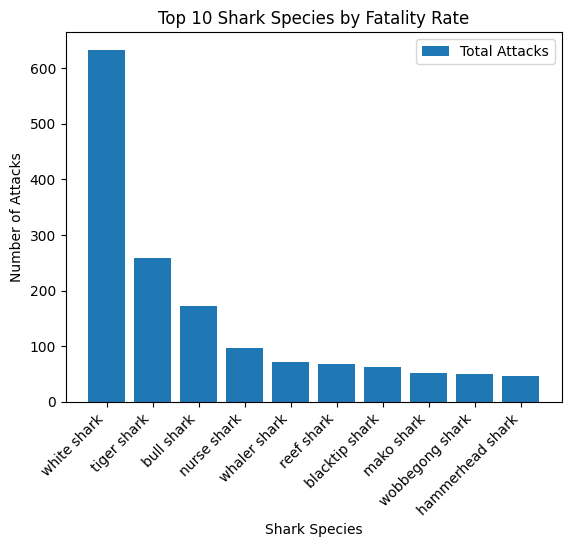

In [99]:
# The overal count of attacks per species, disregard the group that is "unconfirmed":
per_species = shark_attacks.loc[~(shark_attacks["Species"] == "unconfirmed")].groupby("Species").size()
# Sort them so we use only the top ten: 
top_attacks = per_species.sort_values(ascending=False).head(10)

# Put that in a bar chart
species = top_attacks.index.values

fig, ax = plt.subplots()

x = range(len(top_attacks))
top_attacks_bar = ax.bar(x, top_attacks, label="Total Attacks")

ax.set_xlabel("Shark Species")
ax.set_ylabel("Number of Attacks")
ax.set_title("Top 10 Shark Species by Fatality Rate")
ax.set_xticks(x)
ax.set_xticklabels(species, rotation=45, ha="right")
ax.legend()

plt.show()

# Now let's look at the outcome of the attacks. 
Is there a correlation betweet the species that attack the most and the species that have the most fatal attacks?


However...
Not for every attack both the species and the outcome are confirmed. 

If my goal is to not only look at the total attack count per species but also at the fatality I need to know if the group where both species and outcome are confirmed is a valid representation.

I will have to compare them first: 

In [53]:
# Showing only attacks where species is confirmed
confirm_species = shark_attacks.loc[~(shark_attacks["Species"] == "unconfirmed")].groupby("Species").size()
# Showing only attacks where both species and outcome are confirmed
confirm_both = shark_attacks.loc[~((shark_attacks["Species"] == "unconfirmed") | (shark_attacks["Outcome"] == "unconfirmed"))].groupby("Species").size()

# Comparison: 
comparison = pd.concat([confirm_species, confirm_both], axis=1, sort=True)
comparison.columns = ["confirmed species", "confirmed outcome and species"]

# add a third column with the difference between "confirmed species" and "confirmed outcome and species"
comparison["difference"] = comparison["confirmed species"] - comparison["confirmed outcome and species"]

# Sort by "confirmed outcome and species" in descending order
comparison = comparison.sort_values("difference", ascending=False)

comparison

,confirmed species,confirmed outcome and species,difference
Species,,,
white shark,633,625,8
tiger shark,259,257,2
wobbegong shark,49,48,1
blue shark,41,40,1
nurse shark,96,95,1
...,...,...,...
gummy shark,1,1,0
hammerhead shark,47,47,0
hooked shark,1,1,0


Those differences are tiny, I can work with the group where both species and outcome are confirmed.

In [83]:
# Selecting only the attacks where both species and outcome are confirmed: 
df_confirmed_species = shark_attacks.loc[~((shark_attacks["Species"] == "unconfirmed") | (shark_attacks["Outcome"] == "unconfirmed"))]

# count the total amount of attacks per species.
total_attacks = df_confirmed_species.groupby('Species').size()

# count the total amount of fatal attack per species.
fatal_attacks = df_confirmed_species[df_confirmed_species["Outcome"] == "fatal"].groupby("Species").size()

In [84]:

# # calculate the fatality rate percentage per species, replace null values with 0
# fatality_rate = (fatal_attacks / total_attacks * 100).round(2).fillna(0)

In [59]:
# Top ten when looking at total attacks
top_total_attacks = total_attacks.sort_values(ascending=False).head(10)
# Top ten when looking at fatal attacks
top_fatal_attacks = fatal_attacks.sort_values(ascending=False).head(10)

In [86]:
len(top_total_attacks)

10

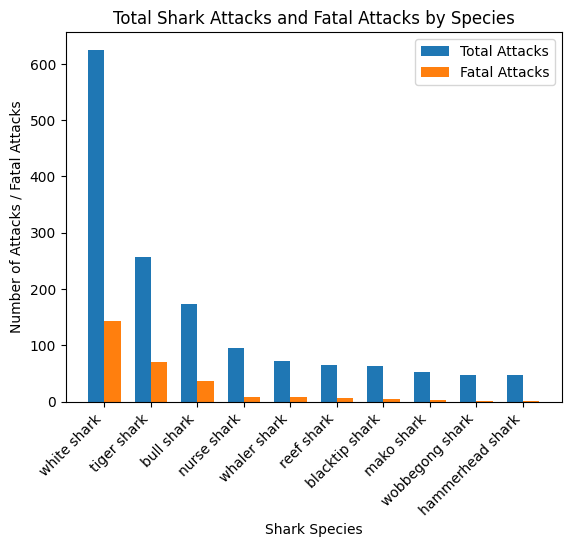

In [75]:
# Barchart showing the fatal attacks versus total attacks

# Defining the data to plot
# Set species as the index
species = top_total_attacks.index.values
total_attacks = top_total_attacks.values
fatal_attacks = top_fatal_attacks.values

# Define the figure and axis objects
fig, ax = plt.subplots()

# Define the locations for the bars so I can place both bars next to eachother
x = np.arange(len(species))

# Define the width of each bar
bar_width = 0.35

# Plot the total attacks bars
total_bar = ax.bar(x, total_attacks, bar_width, label="Total Attacks")

# Plot the fatality rate bars
fatal_bar = ax.bar(x + bar_width, fatal_attacks, bar_width, label="Fatal Attacks")

# Add cosmetics
ax.set_xlabel("Shark Species")
ax.set_ylabel("Number of Attacks / Fatal Attacks")
ax.set_title("Total Shark Attacks and Fatal Attacks by Species")
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(species, rotation=45, ha="right")
ax.legend()

plt.show()

# Fatality rate
We could also look at the fatality rate of these species. 
In other words: the percentage of attacks that is fatal, for all of the species that are in the top ten of total attackers.

In [89]:
# Fatality rate percentage per species, for all species, replace null values with 0
fatality_rate = (fatal_attacks / total_attacks * 100).round(2).fillna(0)
# Show the fatality rate for the species we just found
top_fatality_rate = fatality_rate.loc[top_total_attacks.index.values]
top_fatality_rate

Species
white shark         22.88
tiger shark         27.24
bull shark          21.39
nurse shark          1.05
whaler shark         9.72
reef shark           0.00
blacktip shark       1.59
mako shark           3.85
wobbegong shark      0.00
hammerhead shark     4.26
dtype: float64

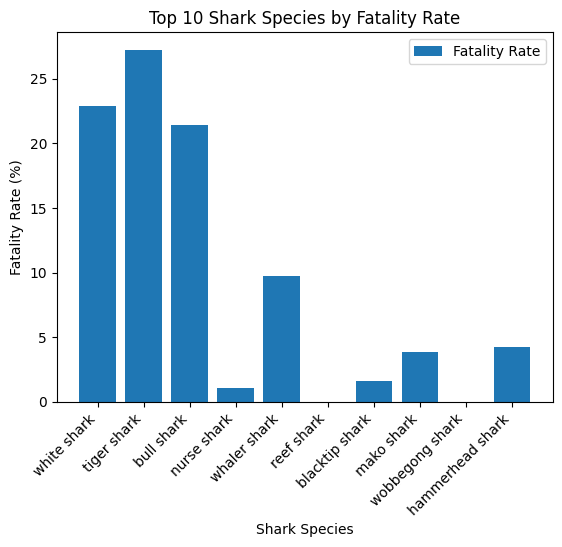

In [95]:
# Define the data to plot
species = top_fatality_rate.index.values
fatality_rates = top_fatality_rate.values

# Define the figure and axis objects
fig, ax = plt.subplots()

# Define the locations for the bars
x = range(len(species))

# Plot the fatality rate bars
fatality_bar = ax.bar(x, fatality_rates, bar_width, label="Fatality Rate")

# Add cosmetics
ax.set_xlabel("Shark Species")
ax.set_ylabel("Fatality Rate (%)")
ax.set_title("Top 10 Shark Species by Fatality Rate")
ax.set_xticks(x)
ax.set_xticklabels(species, rotation=45, ha="right")
ax.legend()

plt.show()